# Reflect Tables into SQLAlchemy ORM

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# View all of the classes that automap found
Base.classes.keys()
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [4]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Convert the result to a datetime object
if most_recent_date:
    most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d').date()
    print("Most Recent Date:", most_recent_date)
else:
    print("No data available.")



Most Recent Date: 2017-08-23


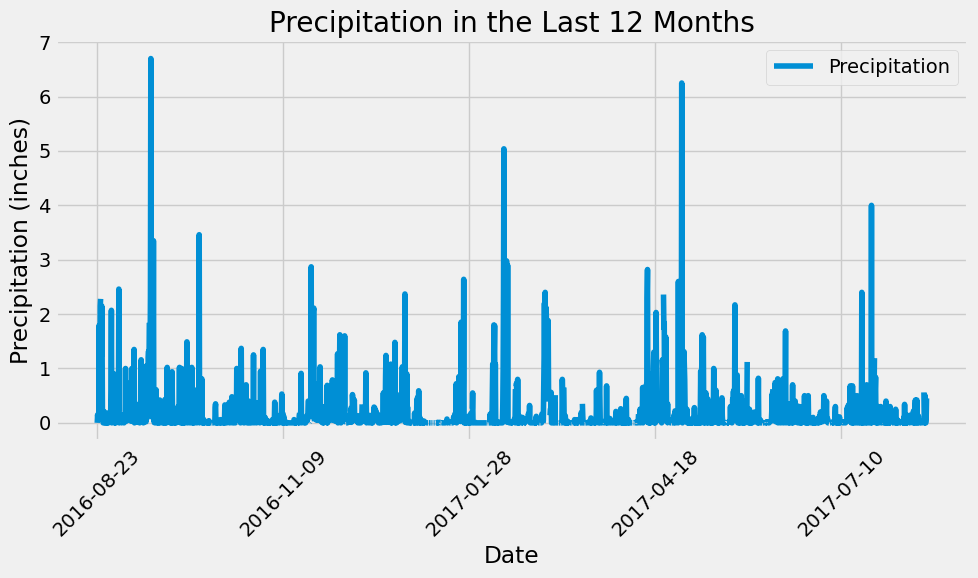

In [5]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10, 6))
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()

# Print the summary statistics
print(summary_stats)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print("Total number of stations:", total_stations)


Total number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations and their row counts
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the most active station
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).first()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats

# Print the temperature statistics
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


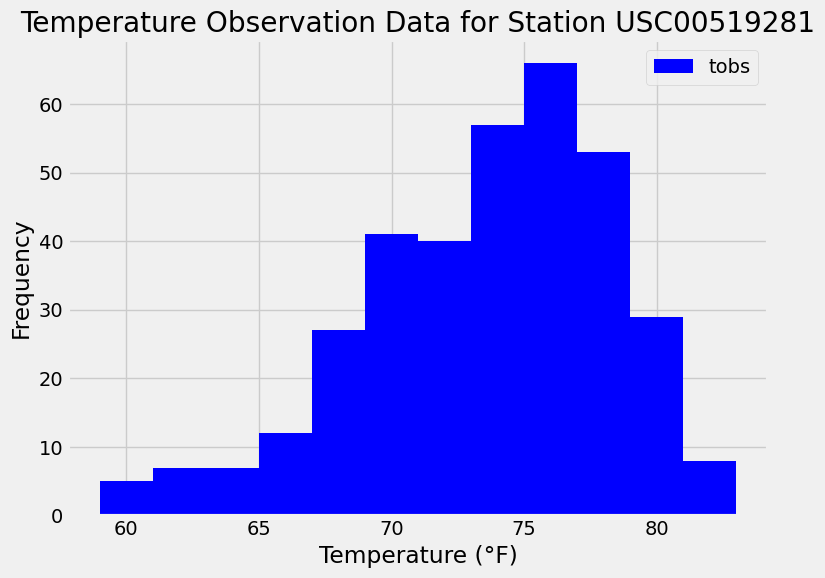

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = active_stations[0][0]

# Calculate the most recent date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert the result to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()

# Calculate the date 12 months ago from the most recent date
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query temperature observation data for the last 12 months for the most active station
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Extract the temperature values
temperature_values = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_values, bins=12, color='blue')
plt.title(f"Temperature Observation Data for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Close Session

In [10]:
# Close Session
session.close()